<a href="https://colab.research.google.com/github/OscarUngsgard/Python-Financial-Engineering/blob/master/Derivative_valuations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Default title text
Imports = "" #@param {type:"string"}
#Imports
from datetime import datetime
from datetime import timedelta  
!pip install workdays
import workdays
#import datetime
from dateutil.relativedelta import relativedelta
from collections import defaultdict
import os
import sys, os
import io
import warnings
import math

import numpy as np
from numpy import linspace

import random
from random import choices

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data as wb
import pandas_datareader.data as web
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
register_matplotlib_converters()


from pylab import plot,show,hist,figure,title

!pip install yfinance
import yfinance as yf
!pip install yahoo_fin
from yahoo_fin import options
yf.pdr_override()

from scipy import stats
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import basinhopping

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

**Functions to read in stock data**

In [0]:
#Functions to read in stock data from Yahoo Finance
def returns(YahooTickers, starttime = datetime.today()-relativedelta(months=+12)):   #format tickers = ['AXFO.ST','HM-B.ST','PCELL.ST','SOLT.ST']
    mydata = pd.DataFrame()
    for t in YahooTickers:
        mydata[t] = yf.Ticker(t).history(start=starttime, end = datetime.today())["Close"]
        returns = np.log(mydata/mydata.shift(1))
    #print("Number of null values filled: ")
    #print(np.isnan(returns).sum())
    returns.fillna(method='ffill', inplace=True) #NA = last value
    returns = returns.apply(lambda x: x.fillna(x.mean()),axis=1) #NA = average of rows if never available.
    return returns[1:]
def today_value(YahooTickers):
    mydata = pd.DataFrame()
    for t in YahooTickers:
        mydata[t] = yf.Ticker(t).history(start='2020-1-1', end = datetime.today())["Close"]
    return mydata.iloc[-1].values

**Simple monte carlo option pricer**

In [0]:
def monte_carlo_option_pricer(Ticker,Maturity,Strike,impvol, r = -0.0031, iterations = 10**6,Put=False):
  M = iterations
  K = Strike
  T = workdays.networkdays( datetime.today(), datetime.strptime(Maturity, '%Y-%m-%d') )/252 
  S = today_value(Ticker)*np.ones(M)
  dw = np.random.normal(0, np.sqrt(T), size=(1, M))
  S = S * ( np.exp( (r - impvol**2/2)*T + impvol*dw))
  if Put:
    payoff = np.fmax(K-S,0)
  else:
    payoff = np.fmax(S-K,0)
  price = np.exp(-r*T)*np.mean(payoff)
  return price

In [0]:
monte_carlo_option_pricer(["^OMX"], '2020-07-20', 1670, 0.235, Put=False)

59.07183705948702

**GARCH Volatility Functions**

In [0]:
#GARCH helper functions
def neg_GARCH_likelihood_function_variance_targetting(params,returns):
    alpha,beta = params
    omega = (returns.var().values)*(1-alpha-beta)
    mu_sq = (returns**2).iloc[1:]
    nu = np.zeros(np.size(mu_sq-1))#*returns.var()
    log_likelihood = np.zeros(np.size(nu))
    nu[0] = (returns**2).iloc[0]  
    log_likelihood[0] = - np.log(nu[0]) - mu_sq.iloc[0]/nu[0]
    for i in range(np.size(nu)-1):
        nu[i+1] = omega + alpha*mu_sq.iloc[i]+beta*nu[i]
        log_likelihood[i+1] = - np.log(nu[i+1]) - mu_sq.iloc[i+1]/nu[i+1]
    return -sum(log_likelihood)

def GARCH_fitting_variance_targetting(returns):
    abstol = 1e-10
    cons = ({'type': 'ineq', 'fun': lambda x: x - abstol})
    init_guess = [0.08, 0.9]
    opt_results = minimize(neg_GARCH_likelihood_function_variance_targetting, init_guess,args=returns,constraints = cons)
    GarchParams = {"alpha" : opt_results.x[0],"beta":opt_results.x[1],"omega":list((returns.var().values)*(1-opt_results.x[0]-opt_results.x[1]))}
    return GarchParams.values()

#GARCH volatility
def an_vol_GARCH_variance_targetting(returns, printResults = True):
    alpha,beta,omega = GARCH_fitting_variance_targetting(returns)
    mu_sq = (returns**2)#.iloc[1:]
    nu = np.zeros(np.size(mu_sq-1))#*returns.var()
    nu[0] = mu_sq.iloc[0]
    for i in range(np.size(nu)-1):
        nu[i+1] = omega + alpha*mu_sq.iloc[i]+beta*nu[i]
    returns['vol'] = np.sqrt(nu*252) 
    if printResults:     
      returns['vol'].plot(figsize=(20,16))
      print("GarchParams: alpha = {alpha}, beta = {beta}, omega = {omega}".format(alpha = alpha, beta = beta, omega = omega))
      print("Current vol = {}".format([returns['vol'].iloc[-1]]))
      print("long run vol mean = {}".format(np.sqrt(252*returns.var().values[0])))
      plt.ylabel('GARCH Volatility')
      plt.xlabel('Date')
      plt.title(returns.columns[0] + ' GARCH(1,1) volatility plot with variance targetting')
    return (returns['vol'].iloc[-1],alpha,beta,omega)
#Volatility forecast with GARCH
def Garch_average_vol_forecast(returns, endtime, starttime = datetime.today()):
  k = (datetime.strptime(endtime, '%Y-%m-%d') - starttime).days
  VL = returns.var().values
  sigma,alpha,beta,omega = an_vol_GARCH_variance_targetting(returns, printResults=False)
  avg_Variance = VL + ((sigma**2)/252 - VL)*sum([(alpha+beta)**t for t in range(1,k)]) / k
  an_avg_vol = np.sqrt((avg_Variance*252))
  return an_avg_vol

GarchParams: alpha = 0.133178213041418, beta = 0.8461109749888047, omega = [6.150208317317132e-06]
Current vol = [0.28321983841004084]
long run vol mean = 0.27355623675963714


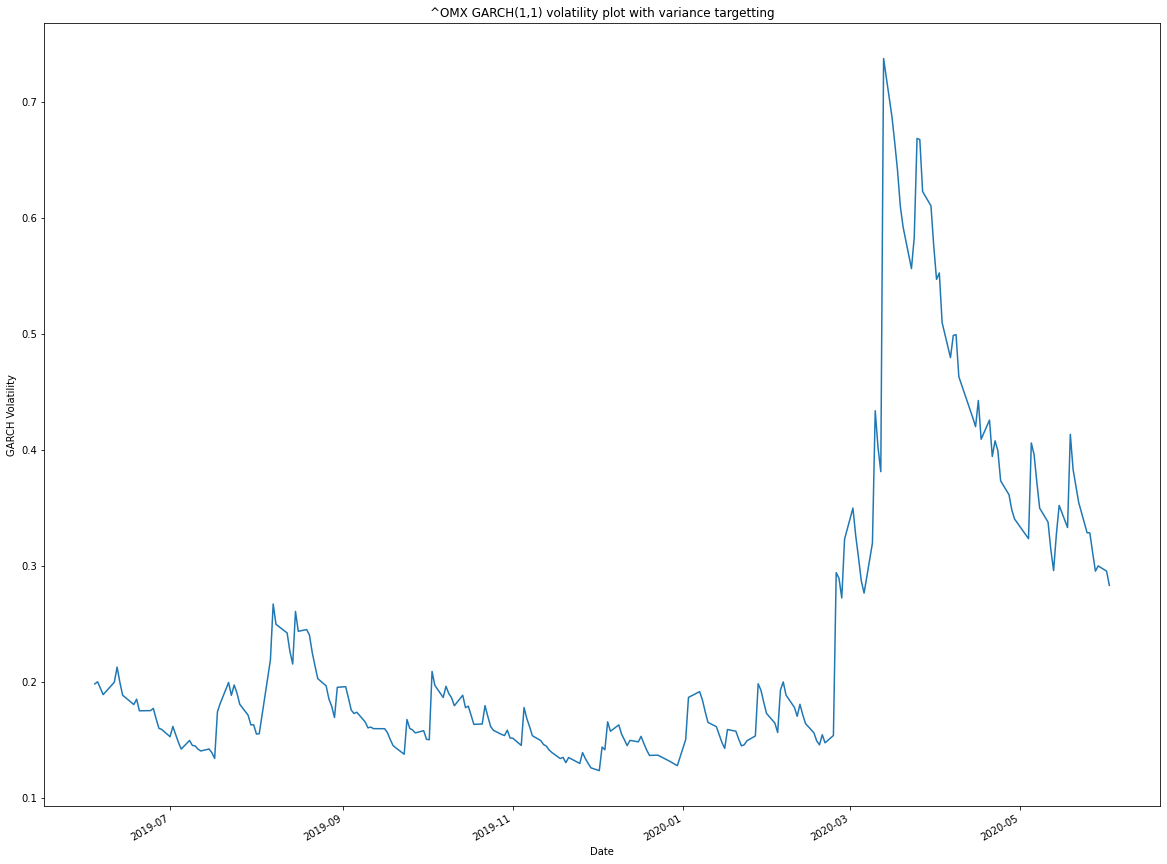

In [0]:
ticker = ['^OMX']
warnings.filterwarnings("ignore") #Filters RuntimeWarning: invalid value encountered in log
output = an_vol_GARCH_variance_targetting(returns(ticker))
warnings.filterwarnings("default")

In [0]:
warnings.filterwarnings("ignore") #Filters RuntimeWarning: invalid value encountered in log
output = Garch_average_vol_forecast(returns(["^OMX"]), '2020-07-17')
print("The forecasted average future volatility is {}".format(output[0]))
warnings.filterwarnings("default")

The average volatility is 0.27972518891669423


**Option pricing using GARCH volatility**

In [0]:
###GARCH Option pricing with Monte Carlo###
#Monte Carlo GARCH option pricer
def Garch_option_pricer(Ticker,Maturity,Strike, r = -0.0031, iterations = 10**6, Put=False):
  '''  
  Calculates fair value of option by simulating the stock movement with the underlying real world GARCH volatility

  Parameters:

  Ticker - ["^OMX"]
  
  Maturity - Maturity date - format '2020-07-17'

  Strike - Strike value

  r - risk free rate

  iterations - Number of simulated paths

  put - True if put, False if Call
  '''
  myReturns = returns(Ticker)
  initvol, alpha, beta, omega = an_vol_GARCH_variance_targetting(myReturns, printResults=False)
  r = r/360 #risk free daily
  M=iterations
  K=Strike
  T = workdays.networkdays( datetime.today(), datetime.strptime(Maturity, '%Y-%m-%d') ) 
  n=T #timesteps set equal to days to maturity
  dt = T/n
  nu = np.zeros((M,n))
  nu[:,0] = (initvol**2)/252 #daily variance rate
  S = np.zeros((M,n))
  S[:,0] = today_value(Ticker)*np.ones(M)
  for i in range(n-1):
    dw = np.random.normal(0, np.sqrt(dt), size=(1, M))
    S[:,i+1] = S[:,i] + r*S[:,i]*dt + (np.sqrt(nu[:,i]))*S[:,i]*dw  #Simulate stock one step forward with GARCH volatility
    nu[:,i+1] = omega + alpha*((S[:,i+1]/S[:,i]-1)**2)+beta*nu[:,i] #Update GARCH variance rate estimate
  if Put:
    payoff = np.fmax(S[:,-1] - K,0)
  else:
    payoff = np.fmax(K - S[:,-1],0)#np.fmax(K - S[:,i+1],0)
  price = np.exp(-r*T)*np.mean(payoff)
  return price,initvol 

In [0]:
warnings.filterwarnings("ignore") #Filters RuntimeWarning: invalid value encountered in log
output = Garch_option_pricer(["^OMX"], '2020-07-20', 1650)
print("The price of the option is {}".format(output[0]))
warnings.filterwarnings("default")

The price of the option is 53.82810093319055


**Screens market for undervalued options compared to the GARCH price**

In [0]:
##Screens stocks of S&P 500 for undervalued ATM call or put options
def SPX_Option_Screener(numberOfStock = 500, call=True):
  sp_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
  sp_list = sp_table[0]['Symbol'].tolist()
  #sp_list = sp_list[::round(len(sp_list)/numberOfStock)]
  impvol_list = np.zeros(np.size(sp_list))
  garchvol_list = np.zeros(np.size(sp_list))
  maturity_list = np.size(sp_list)*[None]
  spot_list = np.zeros(np.size(sp_list))
  price_list = np.zeros(np.size(sp_list))
  GARCH_price_list = np.zeros(np.size(sp_list))
  ClosestATMStrike = np.zeros(np.size(sp_list))
  BS_price_list = np.zeros(np.size(sp_list))
  i=0
  for yahooTicker in sp_list[0:numberOfStock]: 
    ticker = yf.Ticker(yahooTicker)
    maturities = [datetime.strptime(x, '%Y-%m-%d') for x in ticker.options]
    maturity_list[i] = min(maturities, key=lambda x:abs(x-(datetime.today() + relativedelta(months=+6)) ) ).strftime('%Y-%m-%d')
    spot_list[i] = today_value([yahooTicker])
    opt = ticker.option_chain(maturity_list[i])
    ClosestATMStrike[i] = min(opt.calls.strike, key=lambda x:abs(x-spot_list[i]))
    impvol_list[i] = (opt.calls.loc[opt.calls['strike'] == ClosestATMStrike[i]])["impliedVolatility"].values
    price_list[i] = (opt.calls.loc[opt.calls['strike'] == ClosestATMStrike[i]])["lastPrice"].values
    GARCH_price_list[i],garchvol_list[i] = Garch_option_pricer([yahooTicker], maturity_list[i] ,ClosestATMStrike[i], Put=False)
    BS_price_list[i] = monte_carlo_option_pricer([yahooTicker], maturity_list[i],ClosestATMStrike[i], impvol_list[i], Put=False)
    i=i+1
  vol_frame = pd.DataFrame({'Ticker': sp_list, "spot" : spot_list, "Maturity" : maturity_list, "strike" : ClosestATMStrike, "moneyness" : ClosestATMStrike/spot_list,
                            'ImpVol': impvol_list, 'Current GARCH hvol': garchvol_list, 'vol_diff': garchvol_list-impvol_list, 'GARCH_price': GARCH_price_list, 'Listed_price': price_list, "BS_price (from impvol)" : BS_price_list,"GARCH_Price/BS_price" : GARCH_price_list/BS_price_list 
                            })
  return vol_frame

In [0]:
warnings.filterwarnings("ignore") #Filters RuntimeWarning: invalid value encountered in log
output = SPX_Option_Screener(numberOfStock = 5)
warnings.filterwarnings("default")
output.head().sort_values(by = ['GARCH_Price/BS_price'], ascending=False)

,Ticker,spot,Maturity,strike,moneyness,ImpVol,Current GARCH hvol,vol_diff,GARCH_price,Listed_price,BS_price (from impvol),GARCH_Price/BS_price
3,ABMD,222.42,2020-12-18,220.0,0.989120,0.500219,0.593127,0.092908,38.147219,29.23,34.270659,1.113116
2,ABBV,91.15,2020-11-20,90.0,0.987383,0.300361,0.356456,0.056095,9.051315,7.80,8.173299,1.107425
1,ABT,92.53,2020-11-20,92.5,0.999676,0.328620,0.337656,0.009036,8.159825,6.95,8.473039,0.963034
0,MMM,156.31,2020-11-20,155.0,0.991619,0.344245,0.350355,0.006110,14.851631,12.05,15.550381,0.955065
4,ACN,201.68,2020-11-20,200.0,0.991670,0.307716,0.222542,-0.085174,15.446964,14.90,18.081594,0.854292
